In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from util import string_to_yuan,string_to_month

# df = pd.read_json('./sample_p4.txt', encoding='gb18030', lines=True)
# df.dropna(axis=0, subset=['content'], inplace=True)
# print('非空:', len(df))
# df = df.iloc[np.bitwise_and(
#     df['trial_round'].values != '其他', df['trial_round'].values != '刑罚变更'), :]
# print('非其他，非刑法变更:', len(df))
# df = df.iloc[df['content'].apply(is_valid).values, :]
# print('非撤回上诉:', len(df))
# contents = df['content'].values

df = pd.read_csv('rrr.csv')
df.dropna(axis=0, subset=['事实认定','审理意见','判决结果'], inplace=True)

money = []
cnt = 1


def is_valid(t):
    if t.find('撤回上诉') != -1:
        return False
    if t.find('重新审判') != -1:
        return False
    if t.find("申诉理由不能成立") != -1:
        return False
    return True


def get_money(t: str):
    ret = []

    m = re.findall(f"(?<=追缴赃款).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=违法所得).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=所得赃款).*元", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=收受的).*?(?=赃款依法予以没收)", t, re.M)
    ret.extend(m)

    m = re.findall(f"(?<=收受的).*?(?=上缴)", t, re.M)
    ret.extend(m)
    
    rret = []
    for t in ret:
        if re.search('[，。；,.、]',t):
            continue
        rret.append(t)
    ret = rret
    
    if len(ret)==0:
        m = re.findall("(?<=共计).*?元",t,re.S)
        ret.extend(m)
        
        m = re.findall("(?<=总计).*?元",t,re.S)
        ret.extend(m)
        
        m = re.findall("(?<=计).*?元",t,re.S)
        ret.extend(m)
    
    rret = []
    for t in ret:
        if re.search('[，。；,.、]',t):
            # print(t)
            continue
        rret.append(t)
    ret = rret
    
    return ret[0:1]
    
    if len(ret) == 0:
        m = re.findall(f"[\d零一二三四五六七八九十百千万]*元", t, re.M)
        ret.extend(m)
    
    return ret

def money_clear(m:str):
    try:
        return re.search('[\d零一二三四五六七八九十百千万]*元',m).group(0)
    except:
        return m

def select_fact(t:str):
    ret = []
    facts = re.findall("(?<=认证的下列证据予以证实：\n).*?(?=以上)",t,re.DOTALL)
    for fact in facts:
        f0 = fact.split('\n')[0]
        ret.append(f0)
    return ''.join(ret)

def sum_money(m):
    ret = 0
    for t in m:
        t = money_clear(t)
        try:
            ret += string_to_yuan(t)
        except:
            # print(t)
            # break
            pass
    return ret

contents = df['审理意见'].values

for text in contents:
    # fact = select_fact(text)
    fact = None
    if fact:
        m = get_money(fact)
    else:
        m = get_money(text)
    money.append(m)
    
print('金额提取成功比例',np.sum([len(m)!=0 for m in money])/len(money),len(money))
result = []
for m in tqdm(money):
    result.append(sum_money(m))
        
# cnt= 0
# for idx,m in enumerate(money):
#     if len(m)==0:
#         print(idx)
#         print(m)
#         print(df.iloc[idx]['content'])
#         cnt+=1
#     if cnt>10:
#         break


金额提取成功比例 0.23348694316436253 15624


100%|██████████| 15624/15624 [00:00<00:00, 20247.38it/s]


In [2]:
# for i in range(10000):
#     if result[i]!=0:
#         print(i,result[i],df.iloc[i]['审理意见'])

In [3]:
def time_clear(m:str):
    try:
        return re.search('[\d零一二三四五六七八九十个年月]*',m).group(0)
    except:
        return m

def get_month(month):
    try:
        return string_to_month(time_clear(month))
    except:
        return 0

df['金额'] = result
df['金额'].replace(0,np.nan,inplace=True)
df['有期徒刑'] = df['有期徒刑'].apply(get_month)
df['缓刑'] = df['缓刑'].apply(get_month)

In [4]:
df.dropna(axis=0, subset=['罚金','有期徒刑'], how ='all',inplace=True)
df.dropna(axis=0, subset=['金额'], inplace=True)
df.head()
# df.to_csv('res1.csv',index=False)

,index,事实认定,审理意见,判决结果,量刑,量刑全文,长度,金额,罪名,有期徒刑,...,多次索贿,致使公共财产、国家和人民利益遭受损失,为他人谋取职务提拔、调整,曾因受过处分,曾因*罪,赃款赃物用于非法活动,无法追缴,造成恶劣影响,造成严重后果,通过其他国家工作人员职务上的行为
9,9369.txt,：被告人高文忠在担任德清县环境保护局环境监察大队副大队长及钟管环保所所长期间，利用负责对德清...,，被告人高文忠身为国家工作人员，利用职务便利，非法收受他人财物共计人民币182600元，其行...,：一、被告人高文忠犯受贿罪，判处有期徒刑七年二个月（刑期从判决执行之日起计算，判决执行以前先...,"['：一、被告人高文忠犯受贿罪', '判处有期徒刑七年二个月（刑期从判决执行之日起计算', ...",：一、被告人高文忠犯受贿罪，判处有期徒刑七年二个月（刑期从判决执行之日起计算，判决执行以前先...,4,182600.0,受贿,0.0,...,False,False,False,False,False,False,False,False,False,False
14,19039.txt,，被告人李某某为甘谷县公安局磐安派出所民警，与甘谷县磐安镇东街村的吸毒人员杨某甲自幼认识。被...,，被告人李某某身为甘谷县公安局磐安派出所民警，负有查禁打击吸毒、贩毒等违法犯罪活动的法定职责...,：一、被告人李某某犯帮助犯罪分子逃避处罚罪，判处有期徒刑一年，犯受贿罪，判处有期徒刑一年，合...,"['：一、被告人李某某犯帮助犯罪分子逃避处罚罪', '判处有期徒刑一年', '犯受贿罪', ...",：一、被告人李某某犯帮助犯罪分子逃避处罚罪，判处有期徒刑一年，犯受贿罪，判处有期徒刑一年，合...,7,15000.0,受贿,24.0,...,False,False,False,False,False,False,False,False,False,False
16,2228.txt,，2012年至今，被告人陈某任重庆市公安局交通管理局车管所考试中心副主任，分管机动车驾驶人科...,，被告人陈某身为国家工作人员，利用职务的便利为他人谋取利益，收受他人贿赂共计24.2万元，其...,：一、被告人陈某犯受贿罪，判处有期徒刑一年六个月，并处罚金十七万元。（已缴纳）（刑期从判决确...,"['：一、被告人陈某犯受贿罪', '判处有期徒刑一年六个月', '并处罚金十七万元']",：一、被告人陈某犯受贿罪，判处有期徒刑一年六个月，并处罚金十七万元,3,60000.0,受贿,18.0,...,False,False,False,False,False,False,False,False,False,False
19,4659.txt,，被告人王某在担任南部县国土局伏虎国土所所长期间，利用职务之便，收受房地产开发商和个体建房户...,，被告人王某作为国家工作人员，利用职务上的便利，非法收受他人财物共计113000元，为他人谋...,：一、被告人王某犯受贿罪，判处有期徒刑一年六个月，宣告缓刑二年，并处罚金人民币100，000...,"['：一、被告人王某犯受贿罪', '判处有期徒刑一年六个月', '宣告缓刑二年', '并处罚...",：一、被告人王某犯受贿罪，判处有期徒刑一年六个月，宣告缓刑二年，并处罚金人民币100，000元,5,113000.0,受贿,24.0,...,False,False,False,False,False,False,False,False,False,False
21,7350.txt,：1、2006年上半年的一天，被告人范辉在巍山县南诏镇南街79号家中，收受巍山县东街64号院...,，被告人范辉无视国家法律，利用担任巍山县城乡建设环境保护局局长的职务之便，多次收受相关项目负...,：一、被告人范辉犯受贿罪，判处有期徒刑十年。（刑期从判决执行之日起计算，判决执行以前先行羁押...,"['：一、被告人范辉犯受贿罪', '判处有期徒刑十年']",：一、被告人范辉犯受贿罪，判处有期徒刑十年,2,133000.0,受贿,120.0,...,False,False,False,False,False,False,False,False,False,False


array([[1.        , 0.24884944],
       [0.24884944, 1.        ]])

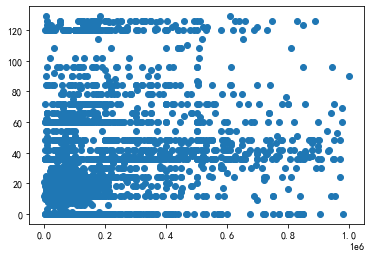

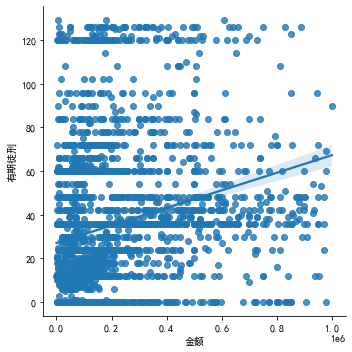

In [5]:
# df = pd.read_csv('res1.csv')

# values = df['金额'].values
# l = values.mean()-values.std()
# r = values.mean()+values.std()

# idx = np.logical_and(l < values,values < 1e6)
# df = df.iloc[idx,:]


from pylab import mpl
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# df.plot.scatter(x='金额',y='有期徒刑')
# df.plot.line(x='金额',y='有期徒刑')

# print(values.mean())
import seaborn as sns
import matplotlib.pyplot as plt
# sns.lineplot(x='金额',y='有期徒刑',data=df)

x = df['金额'].values
y = df['有期徒刑'].values

idx = x<1e6

x = x[idx]
y = y[idx]

plt.scatter(x,y)

dff = pd.DataFrame(data=np.array([x,y]).T,columns=['金额','有期徒刑'])
sns.lmplot(x='金额',y='有期徒刑',data=dff)
np.corrcoef(x,y)

In [6]:
df.to_csv('res_sm.csv',index=False)
# df.head()
